<a href="https://colab.research.google.com/github/melissaortegaa/monografia/blob/main/03_transfer_learning_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

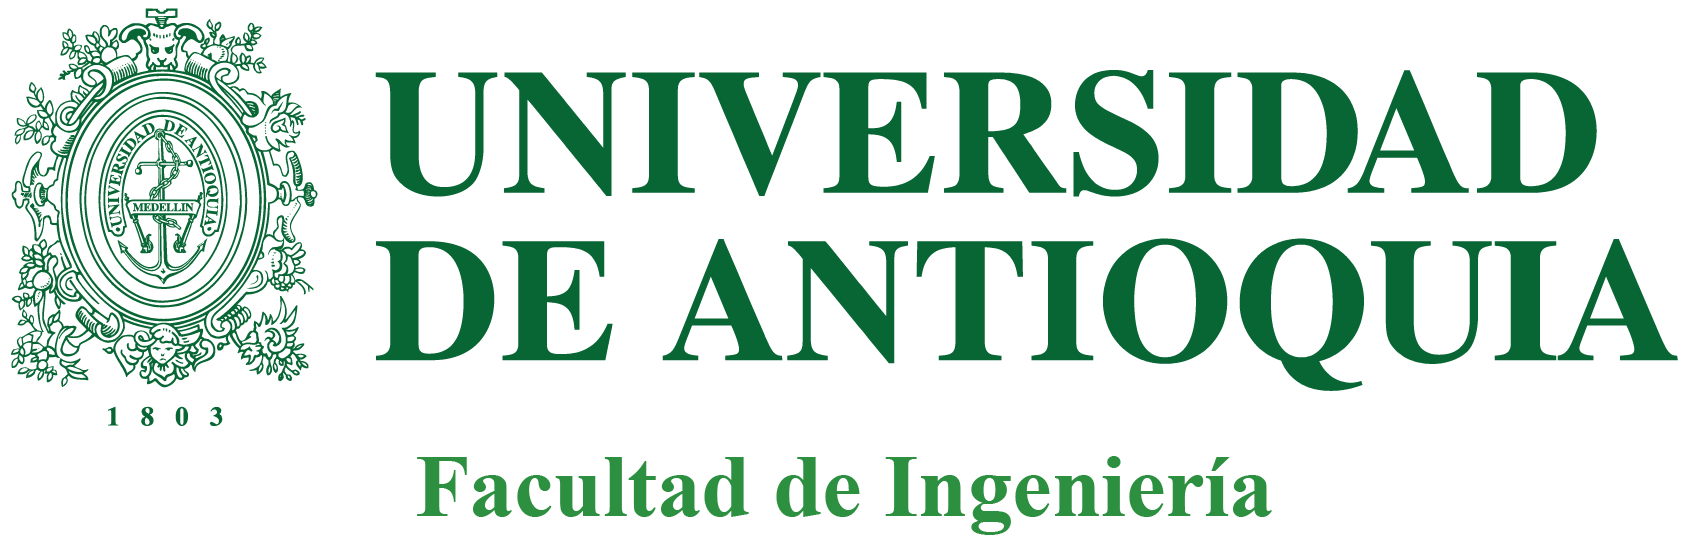
---

**Especialización en Analítica y Ciencia de Datos - Analytics & Data Science**

**Universidad de Antioquia**

**2024**

**Melissa Ortega Alzate**

---

# Exploración de las Redes neuronales convolucionales para la detección de Salmonella *spp.* en aves de corral
### Exploration of Convolutional Neural Networks for the Detection of Salmonella spp. in Poultry

This notebook is the third part of a series of four notebooks associated with the project "Exploration of Convolutional Neural Networks for the Detection of Salmonella spp. in Poultry". The other notebooks can be found in the associated GitHub repository linked below.

<div style="display: flex; align-items: center; justify-content: flex-end; position: fixed; bottom: 10px; right: 10px;">
  <a href="https://colab.research.google.com/github/tu-usuario/tu-repositorio" style="margin-right: 15px;">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" style="height: 25px;">
  </a>
  <a href="https://github.com/melissaortegaa/monografia" style="margin-right: 15px;">
    <img src="https://img.shields.io/badge/GitHub-000?logo=github&logoColor=fff&style=flat" alt="View on GitHub" style="height: 25px;">
  </a>
</div>

## Objective
Train an image classification model using the pre-trained VGG16 convolutional neural network on feacal poultry images. The model distinguishes between healthy and Salmonella.

## Summary
This notebook covers:


1. Data Preprocessing: Preparing images with techniques like data augmentation.
2. Initial Training: extraact images characteristics using the VGG16 network on the training set and evaluating on the validation set.
3. Fine-tuning: Unfreezing specific layers for improved Salmonella classification.
4. Model Evaluation: Assessing the model's performance with confusion matrix visualization and metric comparison, including the test set.




# Init

### Imports

In [1]:
# Standard library imports
import os
import sys
import random
import zipfile
import warnings
import time
import math

# Visualization
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Data manipulation and processing
import numpy as np
import pandas as pd

# Deep learning frameworks and utilities
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import backend as K

# Callbacks, regularizer and optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Ignore Warnings
warnings.filterwarnings("ignore")

# Clear any previous Keras session to avoid clutter from old models
K.clear_session()

# Confirmation
print('\nThe modules were successfully loaded.')


The modules were successfully loaded.


In [2]:
# Google Drive connection
!pip install -q gdown
import gdown
print('gdown was successfully installed and imported.')

gdown was successfully installed and imported.


### Tensorflow and devices settings

In [3]:
# System configuration
if 'google.colab' in sys.modules:
    print("Setting TensorFlow version in Colab")
    %tensorflow_version 2.x

# Check TensorFlow version
print(f'TensorFlow version: {tf.__version__}')

Setting TensorFlow version in Colab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version: 2.15.0


In [4]:
# GPU configuration
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU.')
    try:
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpu_devices)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('Using CPU.')

Using GPU.
1 Physical GPUs, 1 Logical GPUs


In [5]:
# Hardware devices info
!nvidia-smi

Mon Jun  3 22:17:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0              27W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
# Fixing the random seeds for reproducibility
np.random.seed(42)         # NumPy random seed
tf.random.set_seed(42)     # TensorFlow random seed
random.seed(42)            # Python random seed

print("Random seeds are set for reproducibility.")

Random seeds are set for reproducibility.


# Functions

**Function to plot activation maps of a given model layer**

In [7]:
# Function to plot activation maps of a given model layer
def plot_activations(model, layer_name,image_batch,label_batch, n_images=5, n_channels=10):
    """
    Plots the activations of a given intermediate layer for a batch of input images.

    Parameters:
    model: keras.Model - The model to extract the activations from.
    layer_name: str - The name of the intermediate layer to extract the activations from.
    train_generator: keras.utils.Sequence - The data generator for providing input images.
    n_images: int, optional - The number of input images to plot the activations for. Default is 5.
    n_channels: int, optional - The number of channels to plot. Default is 10.

    Returns:
    fig: matplotlib.figure.Figure - The figure containing the activation plots.
    """
    # Create a new model that includes the model and the intermediate layer
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Ensure we only process the desired number of images
    image_batch = image_batch[:n_images]
    label_batch = label_batch[:n_images]

    # Print labels to check for variety
    print("Labels of selected images:", label_batch)

    # Extract the activations of the intermediate layer for the input images
    activations = intermediate_layer_model.predict(image_batch)
    num_channels = min(activations.shape[-1], n_channels)

    # Plot the activations for a subset of the input images
    fig, axes = plt.subplots(n_images, num_channels + 1, figsize=(2 * (num_channels + 1), 2 * n_images))
    for i in range(n_images):
        ax = axes[i, 0]
        ax.imshow(image_batch[i])
        ax.axis("off")
        for j in range(num_channels):
            ax = axes[i, j + 1]
            act = activations[i, :, :, j]
            ax.imshow(act, cmap=plt.cm.Greys_r)
            ax.axis("off")
    return fig

**Function to plot history of training**

In [8]:
# Function to plot history of training
def plot_history(metrics, title='Model training history',tunning=False):
    """
    Function to plot the training history of a model.

    Parameters:
    history: History object returned by the Keras fit method.
    title (str): Title for the plot.

    """
    metrics['epoch'] = history.epoch

    # Plot learning curves
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    metrics_names = ['loss', 'accuracy', 'recall','auc']
    metrics_titles = ['Loss', 'Accuracy', 'Recall', 'AUC']

    # Create the fig
    for i, metric in enumerate(metrics_names):
        # Best epoch
        if metric =='val_loss':
            value_index = metrics[f'val_{metric}'].idxmin()
            value = metrics[f'val_{metric}'].min()
        else:
            value_index = metrics[f'val_{metric}'].idxmax()
            value = metrics[f'val_{metric}'].max()

        index = metrics['epoch'][value_index]
        label = f'best epoch= {str(index + 1)}'

        # Plot
        ax = axes.flat[i]
        ax.plot(metrics[metric], 'o-r')
        ax.plot(metrics[f'val_{metric}'], '--')
        ax.scatter(index, value, s=60, c='green')
        ax.set(ylabel=metrics_titles[i])
        ax.set(title=metrics_titles[i])
        ax.legend(['Train', 'Validation', label])
        ax.set_ylim([metrics[metric].min() - 0.1])
        ax.set(xlabel="Epochs")

        if tunning:
            ax.axvline(EPOCHS, ls='--', lw=1, c='grey')
            ax.legend(['Train', 'Validation', label,'Fine tuning'])

    # Styling
    fig.suptitle(title, fontsize = 12, weight='bold')
    plt.tight_layout()
    plt.show()

    # Adjust space between subplots and title
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Show the plot
    plt.show();

**Function to create confusion matrix**

In [9]:
# Function to create confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    """
    This function prints and plots the confusion matrix.
    """
    # Calcualte the cm
    cm = confusion_matrix(y_true, y_pred)

    # Create the fig
    fig, ax = plt.subplots(figsize=(4, 3))
    fig = sns.heatmap(cm,
                      cmap=plt.cm.YlGnBu,
                      linewidths=.5,
                      cbar=True,
                      fmt='.0f',
                      annot=True,
                      xticklabels=['Healthy', 'Salmonella'],
                      yticklabels=['Healthy', 'Salmonella'])

    # Styling
    plt.title('Confusion matrix', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    plt.ylabel('True label', fontsize=10)
    plt.show()

    return fig

**Funtion to plot sample images**

In [10]:
def show_images(generator):
    '''
    This function take the data generator and show sample of the images
    '''
    # return classes , images to be displayed
    g_dict = generator.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(generator)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'red' if class_name == 'salmo' else 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

# Load the dataset

In [11]:
# Download the preprocessed zip file from Google Drive
!gdown '13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp' -O \
    /tmp/data1.zip

Downloading...
From (original): https://drive.google.com/uc?id=13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp
From (redirected): https://drive.google.com/uc?id=13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp&confirm=t&uuid=1dabc3fe-f62f-4510-83ba-ce70020b7711
To: /tmp/data1.zip
100% 172M/172M [00:04<00:00, 36.3MB/s]


In [12]:
# Define the path of the ZIP file and the extraction directory
local_zip = '/tmp/data1.zip'
extract_dir = '/tmp/data'

# Extract files from the ZIP archive
try:
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction completed successfully.")
except Exception as e:
    print("Error during extraction:", e)

Extraction completed successfully.


In [13]:
# Define directories
base_dir = '/tmp/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Define subdirectories for each class
train_healthy_dir = os.path.join(train_dir, 'healthy')
train_salmo_dir = os.path.join(train_dir, 'salmo')

validation_healthy_dir = os.path.join(validation_dir, 'healthy')
validation_salmo_dir = os.path.join(validation_dir, 'salmo')

test_healthy_dir = os.path.join(test_dir, 'healthy')
test_salmo_dir = os.path.join(test_dir, 'salmo')

# Get lists of files in each folder
train_healthy_fnames = os.listdir(train_healthy_dir)
train_salmo_fnames = os.listdir(train_salmo_dir)

validation_healthy_fnames = os.listdir(validation_healthy_dir)
validation_salmo_fnames = os.listdir(validation_salmo_dir)

test_healthy_fnames = os.listdir(test_healthy_dir)
test_salmo_fnames = os.listdir(test_salmo_dir)

# Print example files names
print(f"Train data examples for 1st class: \n{train_healthy_fnames[:10]}")
print(f"\nTrain data examples for 2nd class: \n{train_salmo_fnames[:10]}")

Train data examples for 1st class: 
['healthy.1480.jpg', 'healthy.926.jpg', 'healthy.1664.jpg', 'healthy.1264.jpg', 'healthy.232.jpg', 'healthy.1454.jpg', 'healthy.1556.jpg', 'healthy.230.jpg', 'healthy.1086.jpg', 'healthy.875.jpg']

Train data examples for 2nd class: 
['salmo.158.jpg', 'pcrsalmo.310.jpg', 'pcrsalmo.168.jpg', 'salmo.246.jpg', 'salmo.1317.jpg', 'salmo.393.jpg', 'salmo.1622.jpg', 'salmo.1588.jpg', 'salmo.381.jpg', 'salmo.2046.jpg']


# Data preprocessing and augmentation

In this section, three main transformations are applied to the training and validation images:

* Resizing: all images are resized to 224x224x3.
* Scaling and normalization: according to VGG16 preprocess_input transformations.
* Augmentation: rotations, shears, zooms, and flips are added to the training data.

In [14]:
# Define training parameters
IMG_SIZE = 224
EPOCHS = 50           # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
STEPS_PER_EPOCH = 20  # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch
BATCH_SIZE = 64       # Number of samples per gradient update
VALIDATION_STEPS = 10

In [15]:
# Transforms will be added to the images to increase the size of the datasets.
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

# Flow training images in batches using train_datagen generator for categorical models.
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        seed=42)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        seed=42)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,  # No shuffle for test data
        seed=42)

Found 4023 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


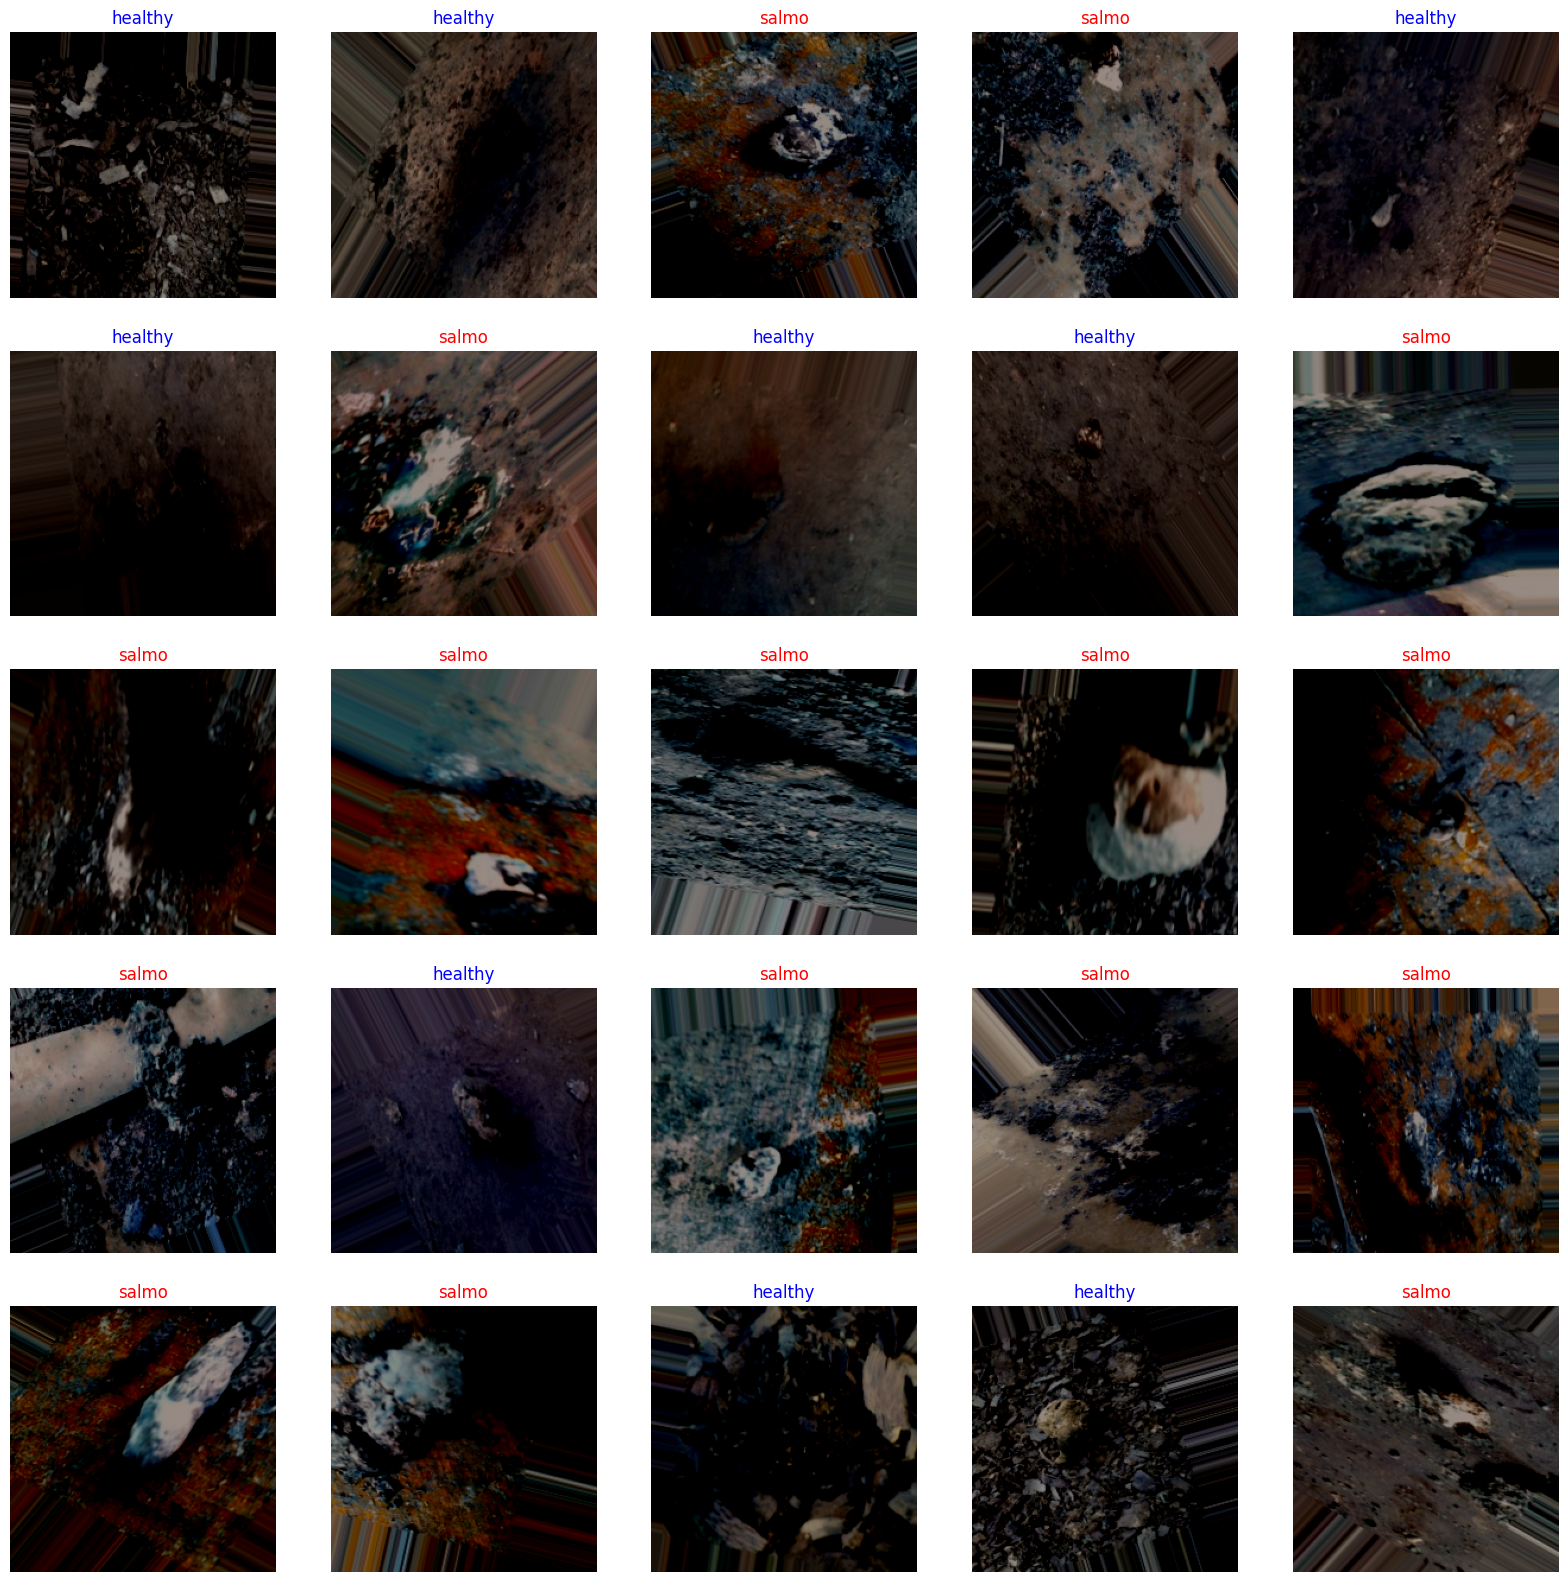

In [16]:
# Visualize sample images after preprocessing and data augmentation
show_images(train_generator)

# VGG16 transfer learning

Using the VGG16 weights, pre-trained on ImageNet. The the new input size upon import and set all layers to not trainable is defined:

In [17]:
# Create the base model from the pre-trained model VGG16 without top layers

base_model = VGG16(weights='imagenet',         # Load weights pre-treined on ImageNet
                   include_top=False,          # Do nor include the ImageNet classifier at the top
                   input_shape=(IMG_SIZE, IMG_SIZE, 3),
                   )

58889256/58889256 [==============================] - 3s 0us/step


In [18]:
# Freeze the convolutional base layers to avoid them to update the weights during the training
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# Obtain a batch of images and labels from the training generator
image_batch, label_batch = next(train_generator)

# Verify that the input shape matches the shape of the images in the batch
print("Input shape:", base_model.input_shape)
print("Image batch shape:", image_batch.shape)

# Pass the batch of images through the VGG16 model and obtain the feature vectors
feature_batch = base_model(image_batch)

# Print the shape of the feature vectors
print("Feature batch shape:", feature_batch.shape)

Input shape: (None, 224, 224, 3)
Image batch shape: (64, 224, 224, 3)
Feature batch shape: (64, 7, 7, 512)


This pre-trained model is used as a feature extractor, it converts each 224x224x3 image into a 7x7x512 block of features. An the end 126 characteristics maps are generated. That output will be then used to train some top layers on the dataset to get the predictions.

Labels of selected images: [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
1/1 [==============================] - 3s 3s/step


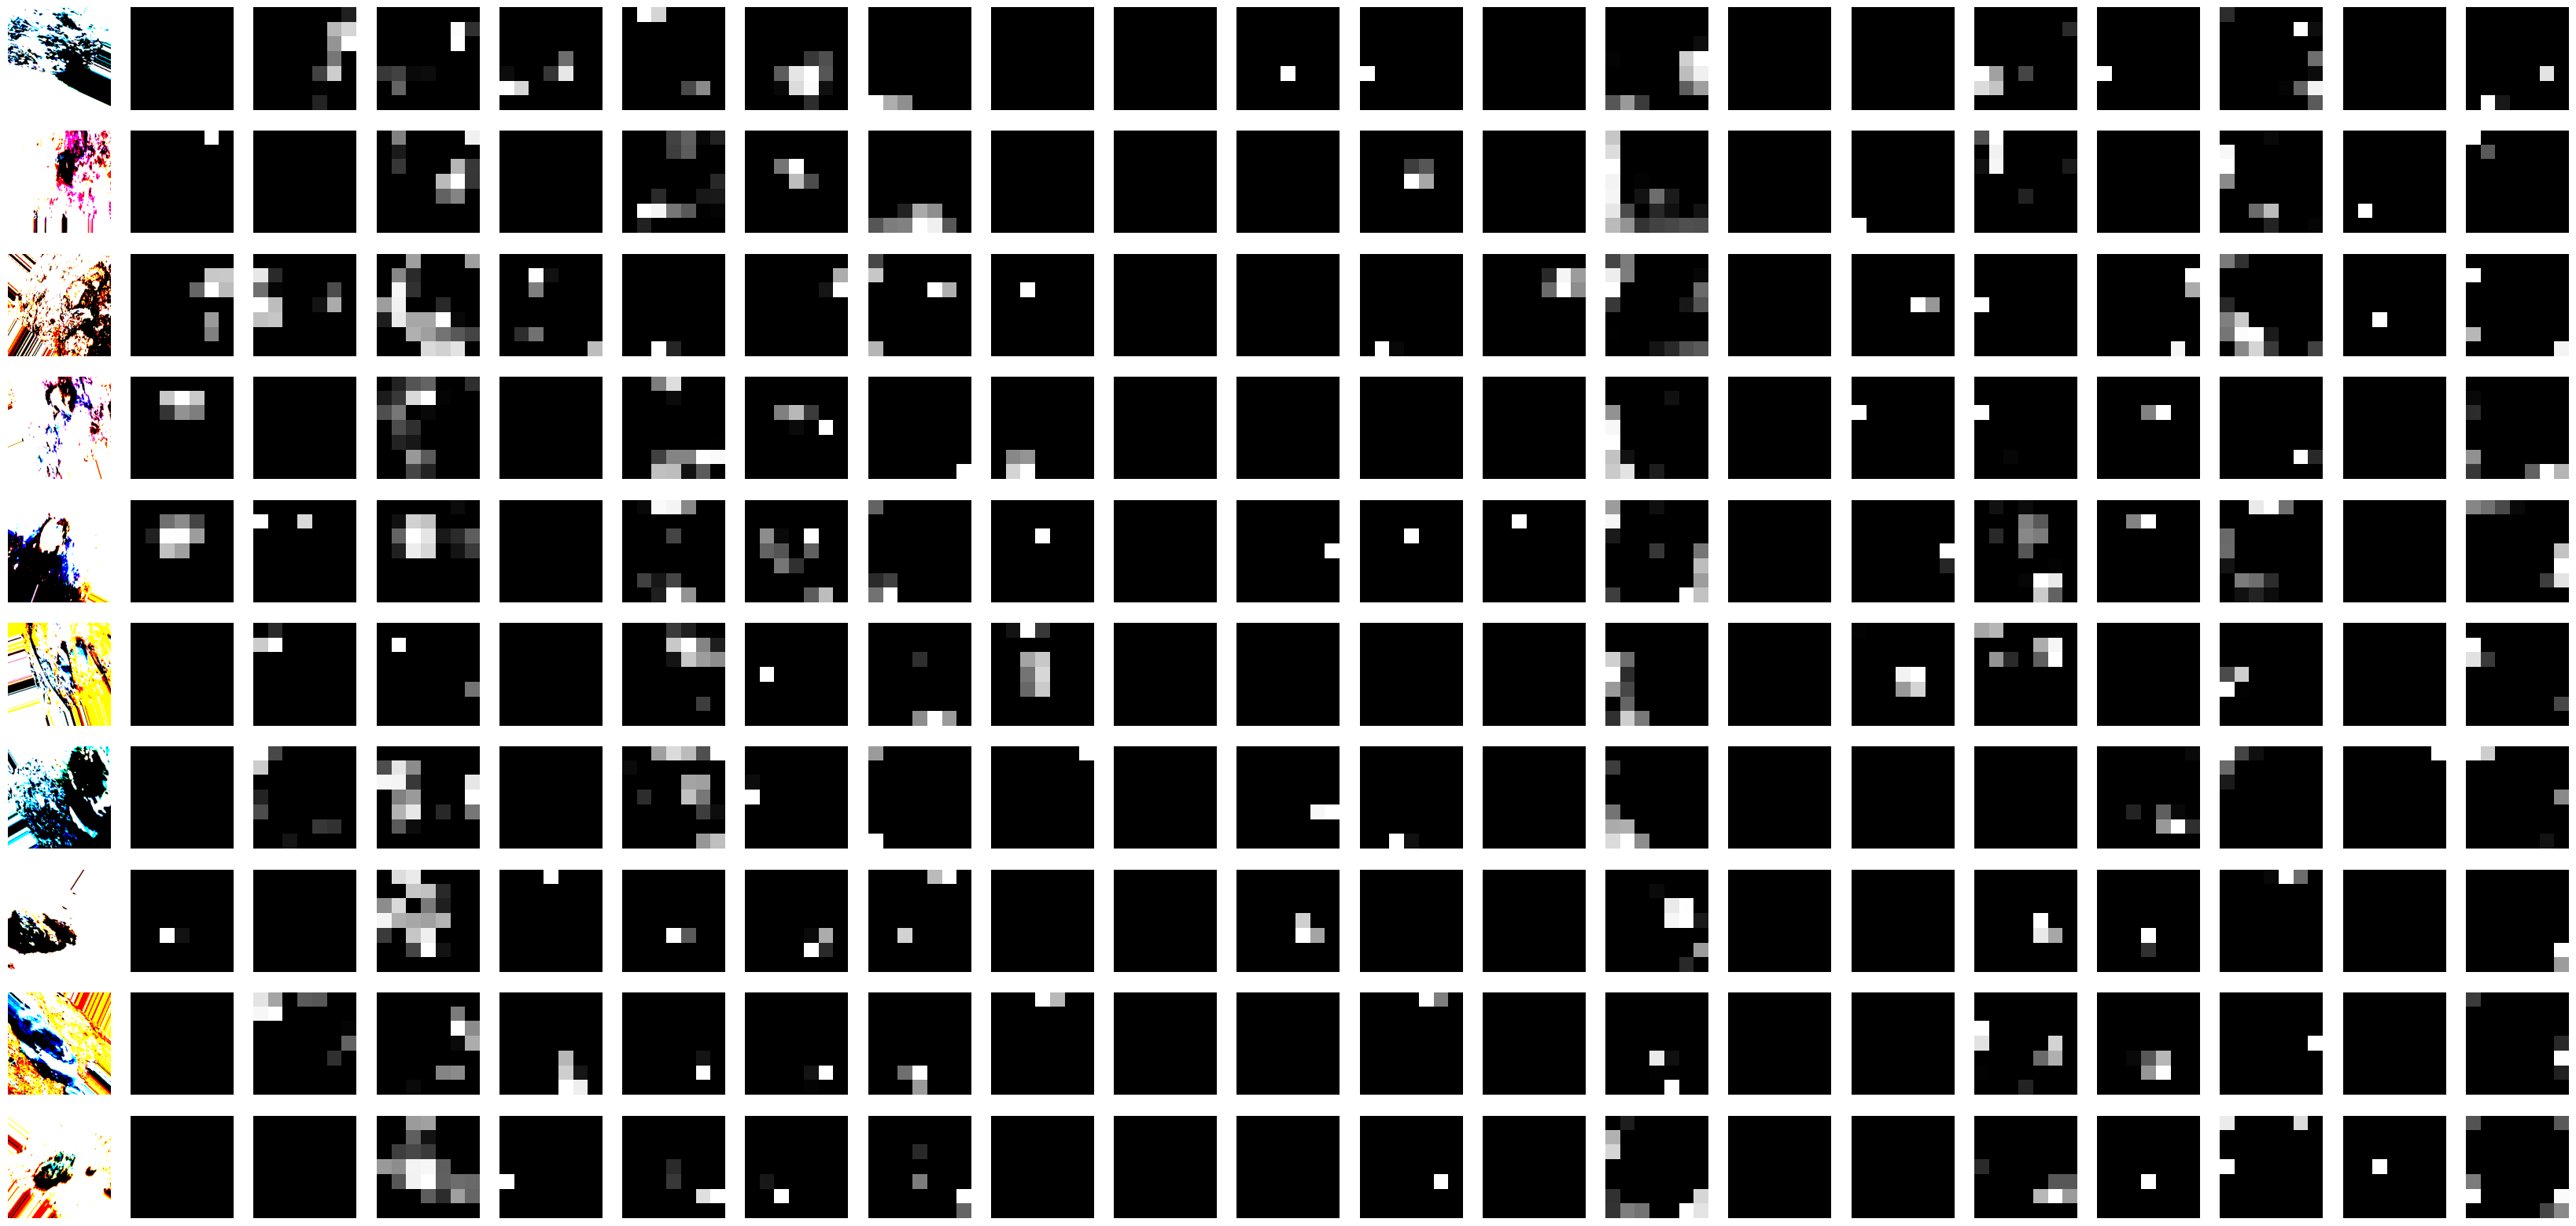

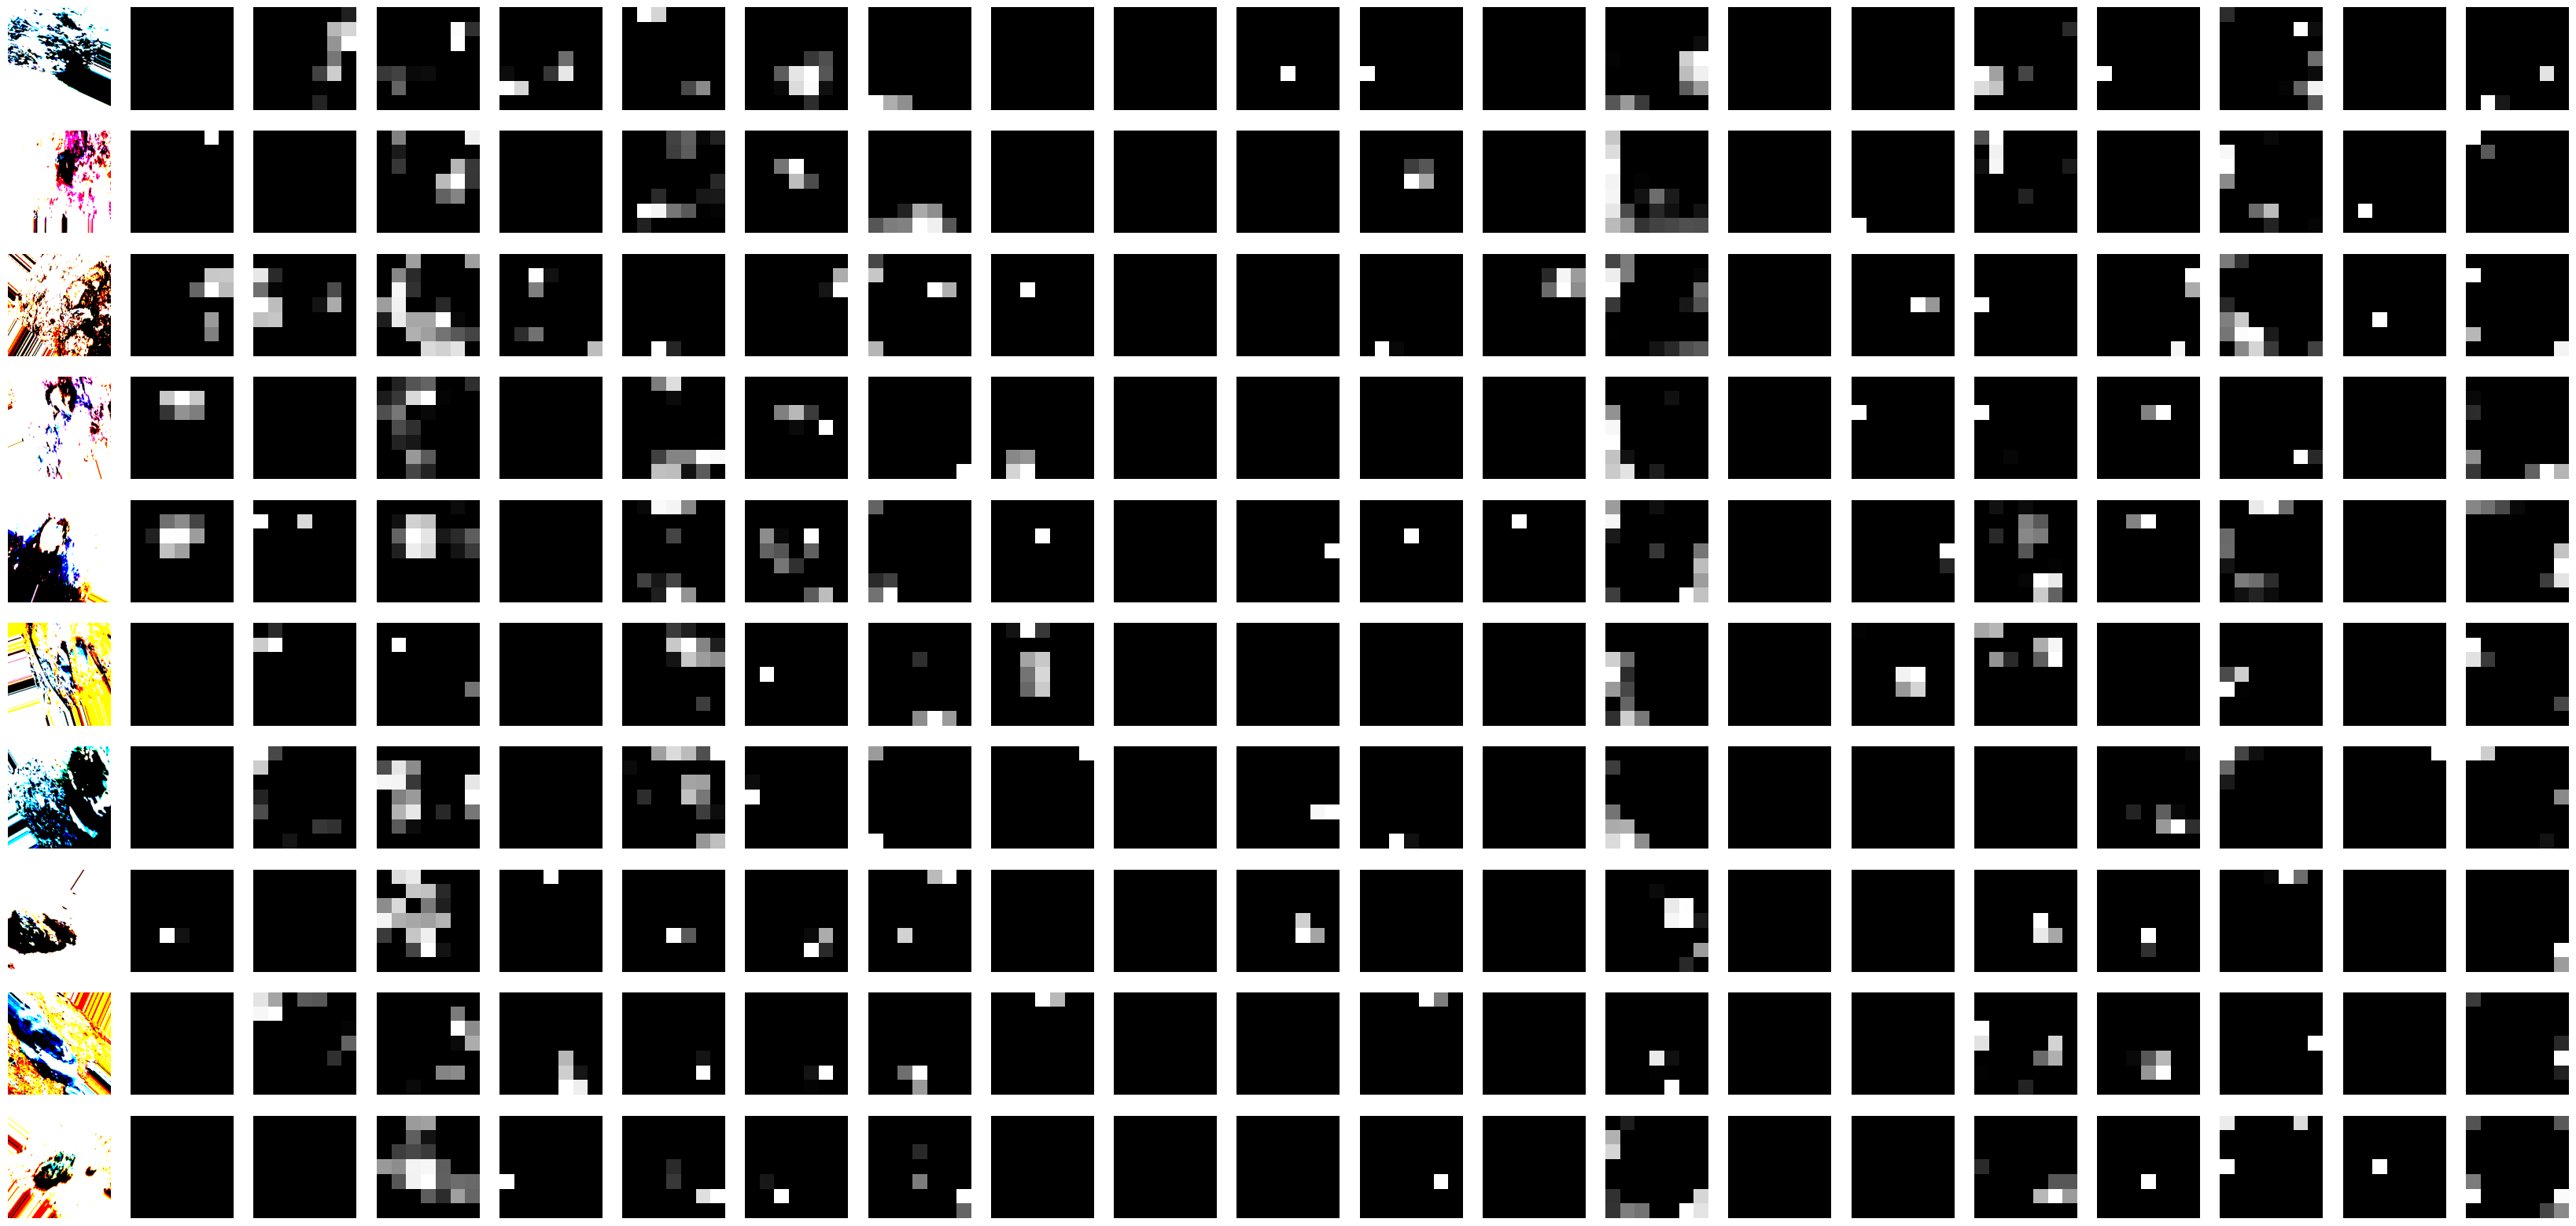

In [20]:
# Plot activations
image_batch, label_batch = next(train_generator)
plot_activations(base_model, 'block5_pool', image_batch, label_batch, n_images=10, n_channels=20)

## Add new layers to the VGG16 model

Using Keras’ functional API to define the vgg16 output as input into a new set of fully-connected layers like so:

In [21]:
# Adding top custom Layers
x = base_model.output

# Convert features of shape 'base_model.output_shape[1:]' to vectors
x = GlobalAveragePooling2D()(x)

# Adding a dense and dropout layer
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01) ,name='densel2')(x)
x = Dropout(0.5, seed=42)(x)

# Adding a dense classifier with softmax activation
output = Dense(2, activation='softmax', name='output')(x)

In [22]:
# Define the new model
transfer_model = Model(inputs=base_model.input, outputs=output)
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [23]:
# Compile the model using the best baseline parameters
transfer_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy', tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])

### Callbacks

In [24]:
# Define early stopping parameters
earlystop = EarlyStopping(monitor='val_loss',mode= 'min', patience=20, verbose=1, restore_best_weights=True)

# Define the ModelCheckpoint callback to save the best model based on the validation metric
checkpoint = ModelCheckpoint('best_vgg_model.keras', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

### Train the transfer model

In [25]:
# Train the transfer model
history = transfer_model.fit(train_generator,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            epochs = EPOCHS,
                            validation_data = validation_generator,
                            validation_steps = VALIDATION_STEPS,
                            verbose=1,
                            callbacks = [earlystop, checkpoint],
                            )

Epoch 1/50
20/20 [==============================] - 37s 1s/step - loss: 6.3307 - accuracy: 0.6141 - recall: 0.6141 - auc: 0.6647 - val_loss: 5.5124 - val_accuracy: 0.7156 - val_recall: 0.7156 - val_auc: 0.8238
Epoch 2/50
20/20 [==============================] - 24s 1s/step - loss: 5.7433 - accuracy: 0.7367 - recall: 0.7367 - auc: 0.8149 - val_loss: 5.2408 - val_accuracy: 0.8172 - val_recall: 0.8172 - val_auc: 0.9057
Epoch 3/50
20/20 [==============================] - 33s 2s/step - loss: 5.5014 - accuracy: 0.7828 - recall: 0.7828 - auc: 0.8608 - val_loss: 5.0813 - val_accuracy: 0.8391 - val_recall: 0.8391 - val_auc: 0.9198
Epoch 4/50
20/20 [==============================] - 21s 1s/step - loss: 5.2595 - accuracy: 0.8143 - recall: 0.8143 - auc: 0.8875 - val_loss: 4.8718 - val_accuracy: 0.8750 - val_recall: 0.8750 - val_auc: 0.9496
Epoch 5/50
20/20 [==============================] - 22s 1s/step - loss: 4.9858 - accuracy: 0.8363 - recall: 0.8363 - auc: 0.9130 - val_loss: 4.7790 - val_accura

## Evaluation and testing

### Histories plot

In [26]:
# Convert the history to a DataFrame
metrics = pd.DataFrame(history.history)

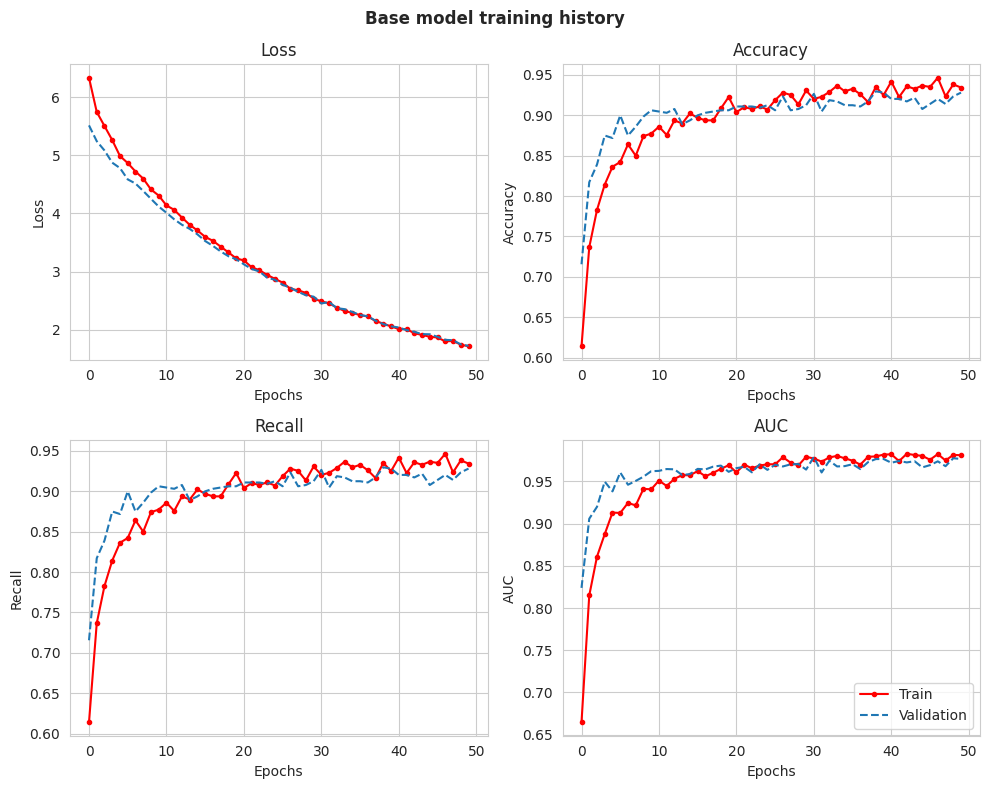

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

metrics_names = ['loss', 'accuracy', 'recall','auc']
metrics_titles = ['Loss', 'Accuracy', 'Recall', 'AUC']

# Create the fig
for i, metric in enumerate(metrics_names):
    ax = axes.flat[i]
    ax.plot(metrics[metric], 'o-r',markersize = 3)
    ax.plot(metrics[f'val_{metric}'], '--')
    ax.set(ylabel=metrics_titles[i], title=metrics_titles[i])
    ax.set(xlabel="Epochs")

ax.legend(['Train', 'Validation'])
# Styling
fig.suptitle("Base model training history", fontsize = 12, weight='bold')
plt.tight_layout()
plt.show()

In [28]:
# Display the best validation metrics

for metric in metrics.columns:
    # Check if the column is a validation metric
    if metric.startswith('val_'):
        print(f"Best {metric}:")
        # Get the maximum value of the metric
        best = metrics.sort_values(by=metric, ascending=False)
        # Print the result
        display(best.head(1))

Best val_loss:


loss  accuracy    recall     auc  val_loss  val_accuracy  val_recall  \
0  6.330708  0.614062  0.614062  0.6647  5.512411      0.715625    0.715625   

    val_auc  
0  0.823839

Best val_accuracy:


loss  accuracy    recall       auc  val_loss  val_accuracy  \
38  2.107055  0.935156  0.935156  0.979453  2.098362      0.929688   

    val_recall   val_auc  
38    0.929688  0.976348

Best val_recall:


loss  accuracy    recall       auc  val_loss  val_accuracy  \
38  2.107055  0.935156  0.935156  0.979453  2.098362      0.929688   

    val_recall   val_auc  
38    0.929688  0.976348

Best val_auc:


loss  accuracy    recall       auc  val_loss  val_accuracy  \
30  2.488995  0.920313  0.920313  0.976954  2.452426      0.926562   

    val_recall   val_auc  
30    0.926562  0.978848

### Confussion matrix

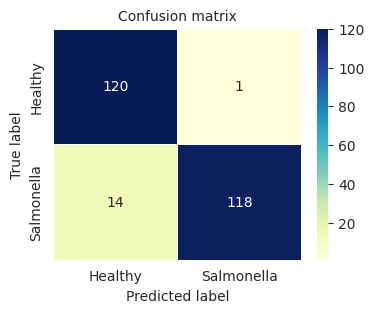

precision    recall  f1-score     support
0              0.895522  0.991736  0.941176  121.000000
1              0.991597  0.893939  0.940239  132.000000
accuracy       0.940711  0.940711  0.940711    0.940711
macro avg      0.943560  0.942837  0.940708  253.000000
weighted avg   0.945648  0.940711  0.940687  253.000000

In [29]:
# Evaluate the model on the validation set
preds = transfer_model.predict(test_generator, verbose = 0)
y_pred = np.argmax(preds, axis=1)

# Get the true labels for the validation set
y_true = test_generator.classes

# Calculate and plot the confusion matrix
plot_confusion_matrix(y_true, y_pred);

# Calculate and plot the confusion matrix
report = classification_report(y_true, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report

## Fine-tuning weights

In [30]:
# Unfreeze the base model
base_model.trainable = True

# How many layers are in the base model
layer_in_base_model = len(base_model.layers)
print(f"Number of layers in the base model: {layer_in_base_model}")

# Fine-tune from this layer onwards
layer_to_unfreeze = 10
start_fine_tuning_at = layer_in_base_model - layer_to_unfreeze
print(f'Start fine tuning at: {start_fine_tuning_at}')

# Freeze all the layers before the `start_fine_tuning_at` layer
for layer in base_model.layers[:start_fine_tuning_at]:
    layer.trainable = False

tuned_model = Model(inputs=base_model.input, outputs=output)

Number of layers in the base model: 19
Start fine tuning at: 9


In [31]:
# See how many parameters are now trainable
tuned_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [32]:
# Define the base learning rate
base_learning_rate = 0.0001

# Compile the transfer_model with the specified configuration
tuned_model.compile(
    loss='categorical_crossentropy',
    optimizer= Adam(learning_rate=base_learning_rate / 10),  # Using Adam optimizer with a very low learning rate
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

In [33]:
# Get the number of trainable variables
num_trainable_variables = len(tuned_model.trainable_variables)

# Print the number of trainable variables
print("Number of trainable variables:", num_trainable_variables)

# Get and print the list of trainable variables
print("\nList of trainable variables:")
transfer_model.trainable_variables

Number of trainable variables: 18

List of trainable variables:


[<tf.Variable 'block3_conv3/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
 array([[[[ 2.49182852e-03, -8.25067237e-03, -1.34461222e-03, ...,
            8.61167070e-03, -3.73780821e-03,  6.45499909e-04],
          [-4.42567188e-03, -1.88350787e-05, -1.74789131e-02, ...,
           -1.74075942e-02, -2.41387892e-03, -2.45446875e-03],
          [-1.45422723e-02,  6.53489307e-03,  4.29056808e-02, ...,
            2.32872367e-03, -8.22560862e-03, -1.34951407e-02],
          ...,
          [ 8.14430788e-03,  4.64800792e-03,  1.78648401e-02, ...,
            1.30022259e-03, -1.02303829e-02, -8.59441701e-03],
          [-1.25717523e-03, -4.16684226e-04, -5.34598716e-03, ...,
           -1.43156825e-02, -5.26516093e-03, -1.92927010e-03],
          [ 7.58334296e-03,  3.03687761e-04,  1.76798610e-03, ...,
           -6.30416349e-03,  5.41360758e-04, -2.08757468e-03]],
 
         [[ 5.62601024e-04, -1.57458056e-02, -1.89978105e-03, ...,
            3.74664553e-03, -7.80931325e-04,  7.8690

### Continue training

In [34]:
# Define the number of epochs for fine-tuning
fine_tune_epochs = 20

# Calculate the total number of epochs including fine-tuning
total_epochs = EPOCHS + fine_tune_epochs

# Fine-tune the model
history_fine_tune = tuned_model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Resume training from the last epoch of previous training
    validation_data=validation_generator,
    callbacks=[earlystop, checkpoint]
)

Epoch 50/70
63/63 [==============================] - 89s 1s/step - loss: 1.6724 - accuracy: 0.9463 - recall_1: 0.9463 - auc_1: 0.9856 - val_loss: 1.6540 - val_accuracy: 0.9482 - val_recall_1: 0.9482 - val_auc_1: 0.9878
Epoch 51/70
63/63 [==============================] - 62s 975ms/step - loss: 1.6187 - accuracy: 0.9615 - recall_1: 0.9615 - auc_1: 0.9911 - val_loss: 1.5785 - val_accuracy: 0.9708 - val_recall_1: 0.9708 - val_auc_1: 0.9942
Epoch 52/70
63/63 [==============================] - 62s 980ms/step - loss: 1.5766 - accuracy: 0.9694 - recall_1: 0.9694 - auc_1: 0.9950 - val_loss: 1.5718 - val_accuracy: 0.9668 - val_recall_1: 0.9668 - val_auc_1: 0.9949
Epoch 53/70
63/63 [==============================] - 62s 982ms/step - loss: 1.5515 - accuracy: 0.9714 - recall_1: 0.9714 - auc_1: 0.9961 - val_loss: 1.5596 - val_accuracy: 0.9681 - val_recall_1: 0.9681 - val_auc_1: 0.9944
Epoch 54/70
63/63 [==============================] - 64s 1s/step - loss: 1.5326 - accuracy: 0.9764 - recall_1: 0.97

### Histories plot

In [35]:
# Get training history into a DataFrame
metrics_tuned = pd.DataFrame(history_fine_tune.history)

# Rename columns names
metrics_tuned = metrics_tuned.rename(columns={'val_recall_1': 'val_recall',
                                              'val_auc_1': 'val_auc',
                                              'auc_1':'auc',
                                              'recall_1':'recall'})

# Concatenate the initial metrics with the fine-tuning metrics
metrics_tuned = pd.concat([metrics, metrics_tuned], ignore_index=True)

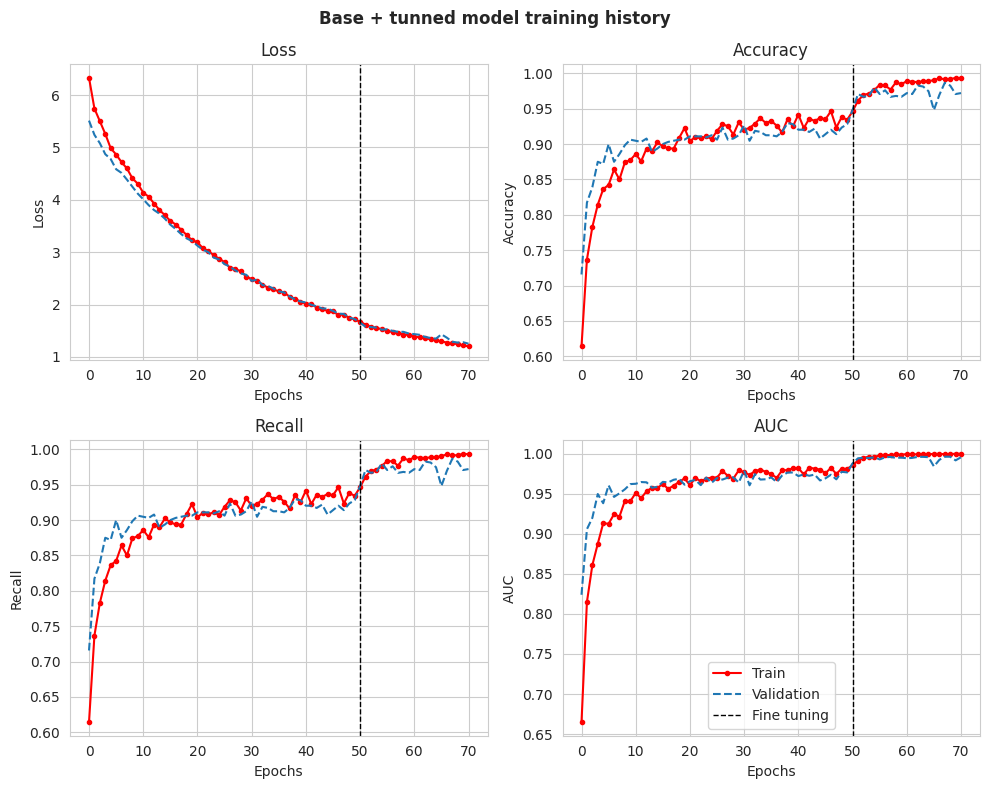

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

metrics_names = ['loss', 'accuracy', 'recall','auc']
metrics_titles = ['Loss', 'Accuracy', 'Recall', 'AUC']

# Create the fig
for i, metric in enumerate(metrics_names):
    ax = axes.flat[i]
    ax.plot(metrics_tuned[metric], 'o-r', markersize = 3)
    ax.plot(metrics_tuned[f'val_{metric}'], '--')
    ax.set(ylabel=metrics_titles[i], title=metrics_titles[i])
    ax.axvline(EPOCHS, ls='--', lw=1, c='black')
    ax.set(xlabel="Epochs")

ax.legend(['Train', 'Validation', 'Fine tuning'])

# Styling
fig.suptitle("Base + tunned model training history", fontsize = 12, weight='bold')
plt.tight_layout()
plt.show()

In [37]:
# Display the best validation metrics

for metric in metrics_tuned.columns:
    # Check if the column is a validation metric
    if metric.startswith('val_'):
        print(f"Best {metric}:")
        # Get the maximum value of the metric
        best = metrics_tuned.sort_values(by=metric, ascending=False)
        # Print the result
        display(best.head(1))

Best val_loss:


loss  accuracy    recall     auc  val_loss  val_accuracy  val_recall  \
0  6.330708  0.614062  0.614062  0.6647  5.512411      0.715625    0.715625   

    val_auc  
0  0.823839

Best val_accuracy:


loss  accuracy    recall       auc  val_loss  val_accuracy  \
67  1.262017  0.991797  0.991797  0.999431  1.290634       0.98672   

    val_recall   val_auc  
67     0.98672  0.996181

Best val_recall:


loss  accuracy    recall       auc  val_loss  val_accuracy  \
67  1.262017  0.991797  0.991797  0.999431  1.290634       0.98672   

    val_recall   val_auc  
67     0.98672  0.996181

Best val_auc:


loss  accuracy    recall       auc  val_loss  val_accuracy  \
67  1.262017  0.991797  0.991797  0.999431  1.290634       0.98672   

    val_recall   val_auc  
67     0.98672  0.996181

### Confussion matrix

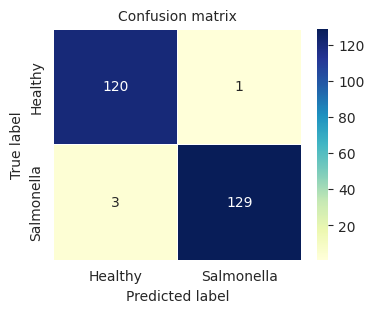

precision    recall  f1-score    support
0              0.975610  0.991736  0.983607  121.00000
1              0.992308  0.977273  0.984733  132.00000
accuracy       0.984190  0.984190  0.984190    0.98419
macro avg      0.983959  0.984504  0.984170  253.00000
weighted avg   0.984322  0.984190  0.984194  253.00000

In [38]:
# Evaluate the model on the validation set
preds = tuned_model.predict(test_generator, verbose = 0)
y_pred = np.argmax(preds, axis=1)

# Get the true labels for the validation set
y_true = test_generator.classes

# Calculate and plot the confusion matrix
plot_confusion_matrix(y_true, y_pred);

# Calculate and plot the confusion matrix
report = classification_report(y_true, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report

### Validation metrics

In [39]:
# Diccionario con los nombres de los modelos y sus respectivos modelos entrenados
models = {
    #'base_model': base_model,
    'tuned_model':tuned_model,
    'transfer_model': transfer_model,
}

In [40]:
# Define the data splits
data_splits = ['Train', 'Validation', 'Test']

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Data Split', 'Loss', 'Accuracy', 'Recall', 'AUC','Time (s)', 'Params'])

# Evaluate the model for each data split and each model
for model_name, model in models.items():
    for split in data_splits:
        # Determine the generator to use based on the data split
        if split == 'Train':
            data_generator = train_generator
        elif split == 'Validation':
            data_generator = validation_generator
        else:
            data_generator = test_generator

        # Evaluate the model on the data split
        start_eval_time = time.time()
        score = model.evaluate(data_generator, steps=VALIDATION_STEPS, verbose=0)
        end_eval_time = time.time()
        eval_time = end_eval_time - start_eval_time
        params = model.count_params()

        # Store the results in the DataFrame
        results_df.loc[len(results_df)] = [model_name, split, score[0], score[1], score[2],score[3], eval_time, params]

# Display the results DataFrame
results_df

Model  Data Split      Loss  Accuracy    Recall       AUC  \
0     tuned_model       Train  1.201846  0.992188  0.992188  0.999627   
1     tuned_model  Validation  1.250014  0.976562  0.976562  0.995310   
2     tuned_model        Test  1.251365  0.984190  0.984190  0.991142   
3  transfer_model       Train  1.193782  0.993750  0.993750  0.999874   
4  transfer_model  Validation  1.265628  0.967188  0.967188  0.994441   
5  transfer_model        Test  1.251365  0.984190  0.984190  0.991142   

    Time (s)    Params  
0  10.929600  14978370  
1   5.271012  14978370  
2   1.341505  14978370  
3  10.646200  14978370  
4   5.326262  14978370  
5   1.652183  14978370

### ROC Curve

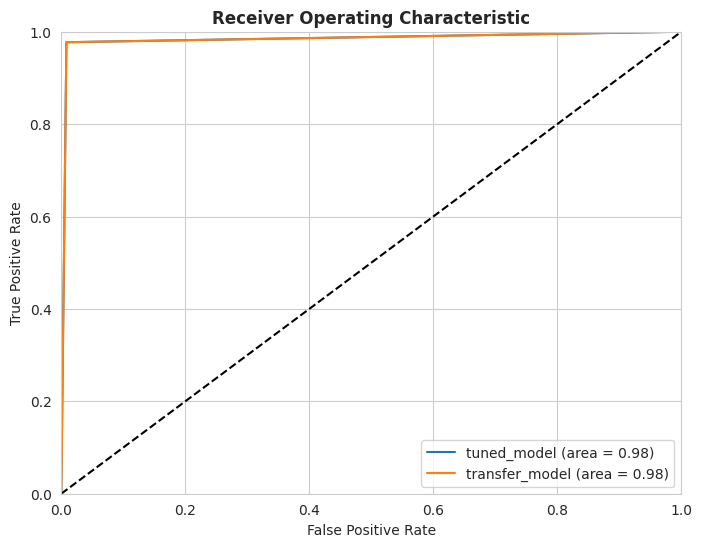

In [41]:
# Dictionary to store predictions and true labels for each model
predictions = {}

# Get predictions and true labels for each model
for name, model in models.items():
    y_true = test_generator.classes
    y_pred = model.predict(test_generator, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    predictions[name] = (y_true, y_pred)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate over the predictions and true labels for each model
for name, (y_true, y_pred) in predictions.items():
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax.plot(fpr, tpr, label=(f"{name} (area = {roc_auc:.2f})"))

# Plot the line of no discrimination
ax.plot([0, 1], [0, 1], 'k--')

# Styling
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic', weight='bold', size=12)
ax.legend(loc="lower right")

# Show the plot
plt.show()

# Visualize predictions

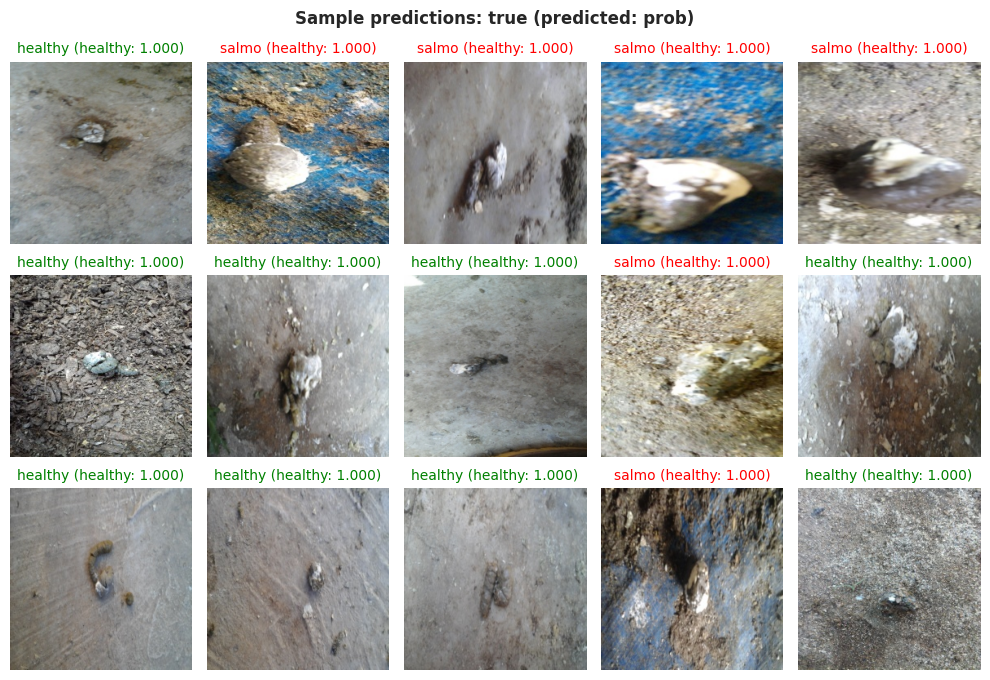

In [42]:
# Cargar el mejor modelo guardado en el archivo "best_model.keras"
best_vgg_model = load_model("best_vgg_model.keras")

# Get probabilities and predictions labels for test images
y_prob = tuned_model.predict(test_generator, verbose=0)
y_hat = np.argmax(y_prob, axis=1)

# Define class names
class_names = ['healthy', 'salmo']

# Create figure and subplots
fig, axs = plt.subplots(3, 5, figsize=(10, 7))
axs = axs.ravel()

# Choose random images from test set
indices = np.random.choice(len(test_generator.filenames), size=15, replace=False)

# Loop through images and display them with their predicted and true labels
for i, index in enumerate(indices):
    # Get image path and load image
    img_path = os.path.join(test_dir, test_generator.filenames[index])
    img = mpimg.imread(img_path)

    # Get true label of image
    if 'healthy' in os.path.basename(img_path):
        true_label = 'healthy'
    else:
        true_label = 'salmo'

    # Get predicted label of image
    pred_label = class_names[y_hat[index]]
    pred_prob = y_prob[index][y_hat[index]]
    pred_label = 'salmo' if pred_label == 1 else 'healthy'

    # Display image in corresponding subplot
    ax = axs[i]
    ax.imshow(img)
    ax.set_title(f"{true_label} ({pred_label}: {pred_prob:.3f})", color="green" if pred_label == true_label else "red", fontsize=10)
    ax.axis('off')

# Add title to figure
fig.suptitle('Sample predictions: true (predicted: prob)', weight='bold', fontsize=12)
plt.tight_layout()
plt.show();

# Best model info

In [43]:
# Load best_model.keras object
best_base_model = load_model('best_vgg_model.keras')
best_base_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   